## Importing the Required Libraries

In [2]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob
# split data into train and test
from sklearn.model_selection import train_test_split
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models
# SVM classifier from scikit learn
from sklearn.svm import LinearSVC

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler



%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Preparing the Data

In [3]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [4]:
stopwords = stopwords.words("english")

In [5]:
print (stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
filename  = '../../Data/Real and fake news/news'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)
# orig_df.columns = ['Text', 'Label']
orig_df = orig_df.replace(to_replace=['FAKE', 'REAL'], value=[0, 1])

In [7]:
orig_df["text"] = orig_df["text"].astype(str)
orig_df["label"] = orig_df["label"].astype(str)
orig_df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


In [8]:
df = orig_df

In [9]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [10]:
new_text, new_label = balanceClasses(df['text'], df['label'])

In [11]:
data = pd.DataFrame(new_text)
data.columns = ['text']
data['label'] = new_label
data = pd.concat([df, data])

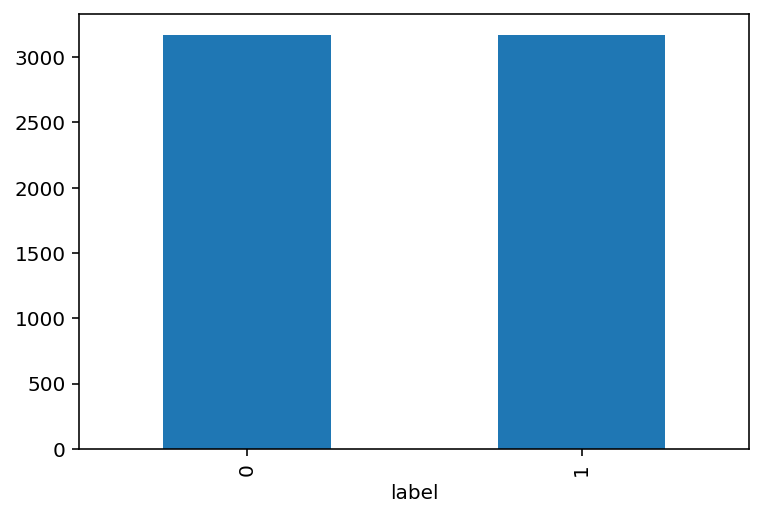

In [12]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [13]:
data=data.sample(frac=1).reset_index(drop=True)

In [14]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceFourColon(x))

In [15]:
import re
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['text'] = data['text'].apply(lambda x: textPattern(x))

In [16]:
data.head()

,text,label
0,Hundreds of Justice Department staff and lawye...,1
1,The Taliban claimed responsibility Friday for ...,1
2,Behind the headlines - conspiracies cover - up...,0
3,Republican presidential nominee Donald Trump a...,0
4,by Yves Smith Yves here It’s hardly a secret t...,0


In [17]:
print(len(data))

6341


In [18]:
# data = orig_df['Text']

data['text'].head()

0    Hundreds of Justice Department staff and lawye...
1    The Taliban claimed responsibility Friday for ...
2    Behind the headlines - conspiracies cover - up...
3    Republican presidential nominee Donald Trump a...
4    by Yves Smith Yves here It’s hardly a secret t...
Name: text, dtype: object

In [19]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data['text'])

In [20]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['hundred', 'staff', 'lawyer', 'gather', 'give', 'nation', 'first', 'african', 'american', 'attorney', 'general', 'send', 'off', 'be', 'more', 'tightly', 'script', 'version', 'thunderous', 'welcome']


In [21]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['hundred', 'staff', 'lawyer', 'gather', 'give', 'nation', 'first', 'african_american', 'attorney_general', 'send', 'off', 'be', 'more', 'tightly', 'script', 'version', 'thunderous', 'welcome', 'receive', 'when']


In [22]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


In [23]:
len(corpus)

6341

In [24]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
#                                            id2word=id2word,
#                                            num_topics=15,
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=50,
#                                            alpha="auto")

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=15,
                                           chunksize=100,
                                           workers=7, # Num. Processing Cores - 1
                                           passes=50,
                                           eval_every = 1,
                                           per_word_topics=True)

In [25]:
lda_model.save("test_model.model")

In [26]:
new_model = gensim.models.ldamodel.LdaModel.load("test_model.model")

In [27]:
train_vecs = []
for i in range(len(data)):
    top_topics = new_model.get_document_topics(corpus[i][:-1], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(15)]
    topic_vec.extend([len(data.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [28]:
train_vecs[2]

[0.00052990625,
 0.0005299062,
 0.08622739,
 0.18535434,
 0.00052990625,
 0.014996663,
 0.00052990566,
 0.0005299057,
 0.000529906,
 0.0005299063,
 0.4449942,
 0.010496542,
 0.0005299069,
 0.0005299063,
 0.2531617,
 2560]

In [29]:
# Using similar split 70/30
X = np.array(train_vecs)
y = np.array(data.label)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, data.index, test_size=0.30, random_state=100)

In [30]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [31]:
model2 = LogisticRegression(random_state=0, tol=1e-5, verbose=1, max_iter=10000)
model2.fit(X_train_scale, y_train)
y_pred2 = model2.predict(X_test_scale)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07619D+03    |proj g|=  8.13295D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     13     15      1     0     0   1.176D-02   1.993D+03
  F =   1992.5055365615663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [32]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2)
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[746 186]
 [212 759]]
Accuracy Score : 0.790856542301629
Report : 
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       932
           1       0.80      0.78      0.79       971

    accuracy                           0.79      1903
   macro avg       0.79      0.79      0.79      1903
weighted avg       0.79      0.79      0.79      1903



In [33]:
# test_doc = corpus[-1]

# vector = new_model[test_doc]
# print (vector)
# For topic importance
# def Sort(sub_li):
#     sub_li.sort(key = lambda x: x[1])
#     sub_li.reverse()
#     return (sub_li)
# new_vector = Sort(vector)
# print (new_vector)

## Vizualizing the Data

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.038841 -0.036293       1        1  15.701066
3      0.207024  0.058517       2        1  14.621058
12     0.031993 -0.187110       3        1   9.173719
10    -0.047928  0.159056       4        1   8.838193
8      0.224496 -0.296994       5        1   7.282460
14     0.273588 -0.149746       6        1   6.755179
7      0.281307  0.304770       7        1   6.027983
6     -0.199562 -0.231483       8        1   5.606329
13    -0.219781 -0.016244       9        1   5.605682
2      0.024256  0.323654      10        1   5.457741
0      0.374515  0.090618      11        1   5.420298
4     -0.346312  0.160597      12        1   3.307457
9     -0.408845 -0.138924      13        1   3.193619
11    -0.197227  0.380381      14        1   1.592376
5     -0.036366 -0.420798      15        1   1.416841, topic_info=            Term          Freq         Total Category  logprob  loglift
20            be  27258.000000  27258.000000  Default  30.0000  30.0000
72          have   8544.000000   8544.000000  Default  29.0000  29.0000
48            do   9055.000000   9055.000000  Default  28.0000  28.0000
162          say  20447.000000  20447.000000  Default  27.0000  27.0000
509     campaign   6738.000000   6738.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1131       order     77.988728   1227.261213  Topic15  -5.5809   1.5008
1255        sign     72.264096    831.318877  Topic15  -5.6571   1.8141
717           re     72.517604   2626.927654  Topic15  -5.6536   0.6670
69    government     66.559495   4093.798265  Topic15  -5.7393   0.1376
297          end     65.383521   1104.291027  Topic15  -5.7572   1.4301

[1139 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
4385       1  0.123727           abortion
4385       9  0.794641           abortion
4385      12  0.081904           abortion
6183      12  0.949754    abortion_clinic
6184      12  0.973551  abortion_provider
...      ...       ...                ...
2822       5  0.119440              youth
2822      11  0.779502              youth
2822      12  0.100581              youth
11942      8  0.937087             zinger
11321      4  0.989956            zionist

[3388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 13, 11, 9, 15, 8, 7, 14, 3, 1, 5, 10, 12, 6])

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
